# Mining functional brain signals 

This notebook exemplary shows the [proposed method](link-to-be-specified) to identify groups of configurations/components with homogeneous envelope dynamics for a complex motor task.

The following steps are taken:

1. Load temporally subsampled log-scaled envelope data of an exemplary subject 
2. Apply dimensionality reduction (PCA or kernel PCA) to condense the feature set
3. Find optimal parameter $\epsilon^*$ for DBSCAN by maxizing the number of homogeneous clusters
4. Train DBSCAN model with fixed $\epsilon^*$
5. Visualization of clusters, features etc.
6. Validation of the clustering

In [1]:
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sys
import datetime
import func_mining as fm

%load_ext autoreload
%autoreload 2
%matplotlib inline

#sys.executable

## Set parameters 

In [2]:
parameters = {'time_segments': np.arange(1,19), # specify time segments in the range 1-18 
              'events_for_clustering':['GetReady','GoCue','3rdHit','4thHit'],
              'events_for_plotting':['GetReady','GoCue','1stHit','2ndHit','3rdHit','4thHit'],
              'scaler': 'mean-var', # feature scaling 
              'preprocessing_method': 'kernelPCA', # 'PCA' can also be selected
              'features_after_pca': ('envelope_mean','envelope_std'), # 'None' or select standardization features added after dim. reduction
              'D_reduced': 10, # number of subspace components used for the clustering step
              'silhouette_threshold': 0.2, # global silhouette threshold
              'N_epsilon_values': 30} # number of discrete epsilon values

current_folder_path = os.path.abspath(os.path.join(fm.__file__, '..', '..'))
DATA_BASE_DIR = os.path.join(current_folder_path,'data')

## 1. Load envelope features for clustering

In [3]:
# temporally subsampled log-envelope data of a set of components computed by NTik-SPoC for one subject:
# time intervals 1-18 correspond to time segments within [-300,2000]ms relative to each event

component_data = fm.data.io.load_csv_format_to_dataframes(os.path.join(DATA_BASE_DIR, 'components.bsv'))

In [4]:
# select events and number of time intervals
clustering_feature_names = fm.features.preprocessing.events_for_clustering(parameters['events_for_clustering'],
                                                                          parameters['time_segments'])

# scaling of features
features_scaled, features_df, features_scaler = fm.features.preprocessing.calculate_feature_matrix_from_dataframe(
    component_data['features'], 
    clustering_feature_names,
    scaler=parameters['scaler'])

## 2. Dimensionality reduction step 

In [5]:
features_pca, preproc_instance,_,_ = fm.features.preprocessing.apply_dimensionality_reduction(features_scaled,
                        method = parameters['preprocessing_method'],N_components=parameters['D_reduced'],
                        kernel_function='rbf')    

pca_feature_names = [parameters['preprocessing_method']+'_comp%d' % i for i in range(parameters['D_reduced'])]
features_pca_df = pd.DataFrame(data=features_pca, index=features_df.index.tolist(), columns=pca_feature_names)

In [6]:
# optional: add standardization features
if parameters['features_after_pca'] is not None:
    clustering_feature_names_add = parameters['features_after_pca']
    features_scaled_add, features_df_add, features_scaler_add = fm.features.preprocessing.calculate_feature_matrix_from_dataframe(
        component_data['features'], 
        clustering_feature_names_add,
        scaler=parameters['scaler'])

    features_all = np.hstack((features_pca,features_scaled_add))
    feature_names_all = list(clustering_feature_names_add)+pca_feature_names
    features_all_df =  pd.DataFrame(data=features_all, index=features_df.index.tolist(), columns=feature_names_all)
else:
    features_all = features_pca
    features_all_df =  pd.DataFrame(data=features_pca, index=features_df.index.tolist(), columns=pca_feature_names)

## 3. Hyperparameter optimization for DBSCAN

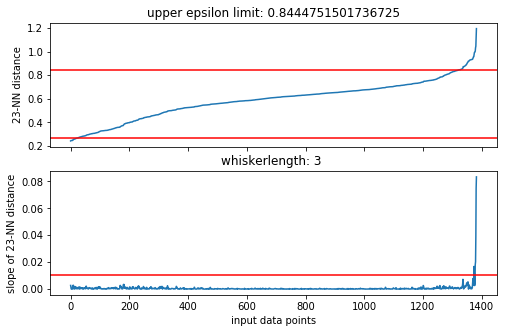

In [7]:
D_clustering = features_all.shape[1]
parameters['D_clustering'] = D_clustering

# as proposed in the DBSCAN paper by Ester et al. (1996):
# set min_samples relative to feature dimensionality
parameters['min_samples']=int(np.rint(D_clustering*2-1)) 
N_neighbors = parameters['min_samples']
    
# as proposed in the DBSCAN paper by Ester et al. (1996):
# k-NN distance plot to determine a suitable epsilon range

distances,epsilon_range = fm.visualization.clustering.plot_kNN_distance(features_all,N_neighbors)
       
epsilon_list = np.linspace(epsilon_range[0],epsilon_range[1],parameters['N_epsilon_values'])
epsilon_list_formatted = [ '%.2f' % elem for elem in epsilon_list ]

In [8]:
[best_param, clusterer, sweep_results]=fm.models.dbscan_util.optimize_dbscan_hyperparameter(features_all,
                                                     epsilon_list,min_samples=parameters['min_samples'],
                                                     silhouette_threshold=parameters['silhouette_threshold'])
parameters['epsilon']=best_param   

selected value: 0.528600252098506


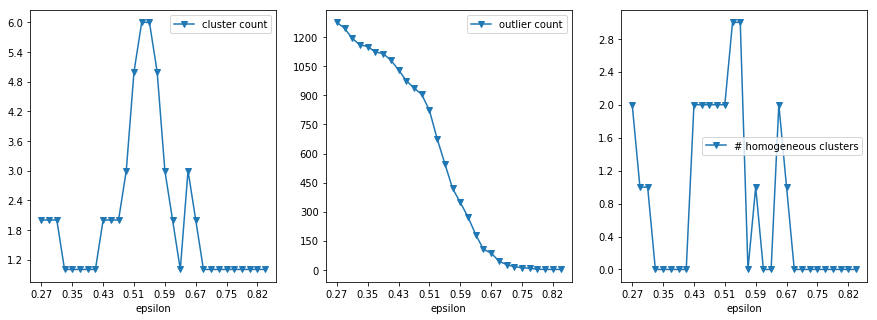

In [9]:
fm.visualization.clustering.plot_cluster_results_for_parameter_sweep(sweep_results,epsilon_list_formatted) 

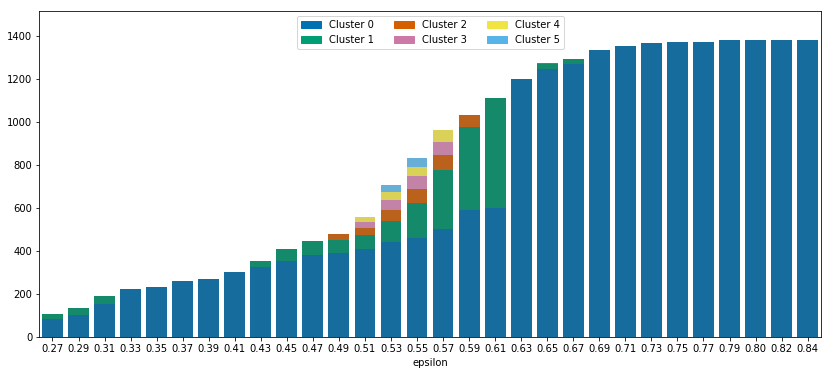

In [10]:
plt.figure(figsize=(14,6)) 
fm.visualization.clustering.plot_cluster_sizes(epsilon_list_formatted, sweep_results['cluster_member_sizes'], 
                                               sort_by_size=True,clustering_axis_str='epsilon')

## 4. Train DBSCAN with fixed parameters

In [11]:
# fit cluster model to given data
clusterer.fit(features_all)

metrics = {}
metrics['N_clusters'] = len(set(clusterer.labels_)) - (1 if -1 in clusterer.labels_ else 0)
metrics['N_outliers'] = np.sum(clusterer.labels_ == -1)

print("Identified %d clusters, %d components are outliers" % (metrics['N_clusters'], metrics['N_outliers']))

metrics['mean_silhouette_score'] = sklearn.metrics.silhouette_score(features_all, clusterer.labels_)
features_all_df['cluster'] = clusterer.labels_
features_df['cluster'] = clusterer.labels_
cluster_labels = clusterer.labels_

component_data['metrics']['cluster_label'] = features_all_df['cluster']

Identified 6 clusters, 677 components are outliers


## 5. Visualization of clusters, features etc.

### 5.1 Samples per cluster

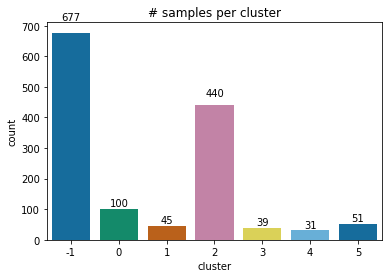

In [12]:
# Note: the label '-1' is assigned to the outlier set

plt.figure()
ax = sns.countplot(x="cluster", data=features_all_df, palette="colorblind")
for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height),
            ha='center', va='bottom')
plt.title('# samples per cluster')
plt.show()

### 5.2 Silhouette scores 

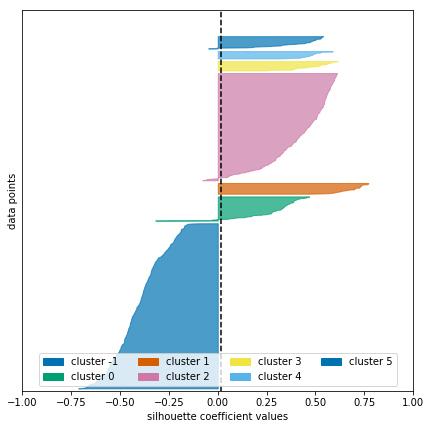

In [13]:
# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(features_all, cluster_labels)

fm.visualization.clustering.plot_silhouette_coefficients(cluster_labels, sample_silhouette_values, 
                                                      metrics['mean_silhouette_score'], plot_legend='true')

### 5.3 Features in PCA / kernel PCA space

<Figure size 432x288 with 0 Axes>

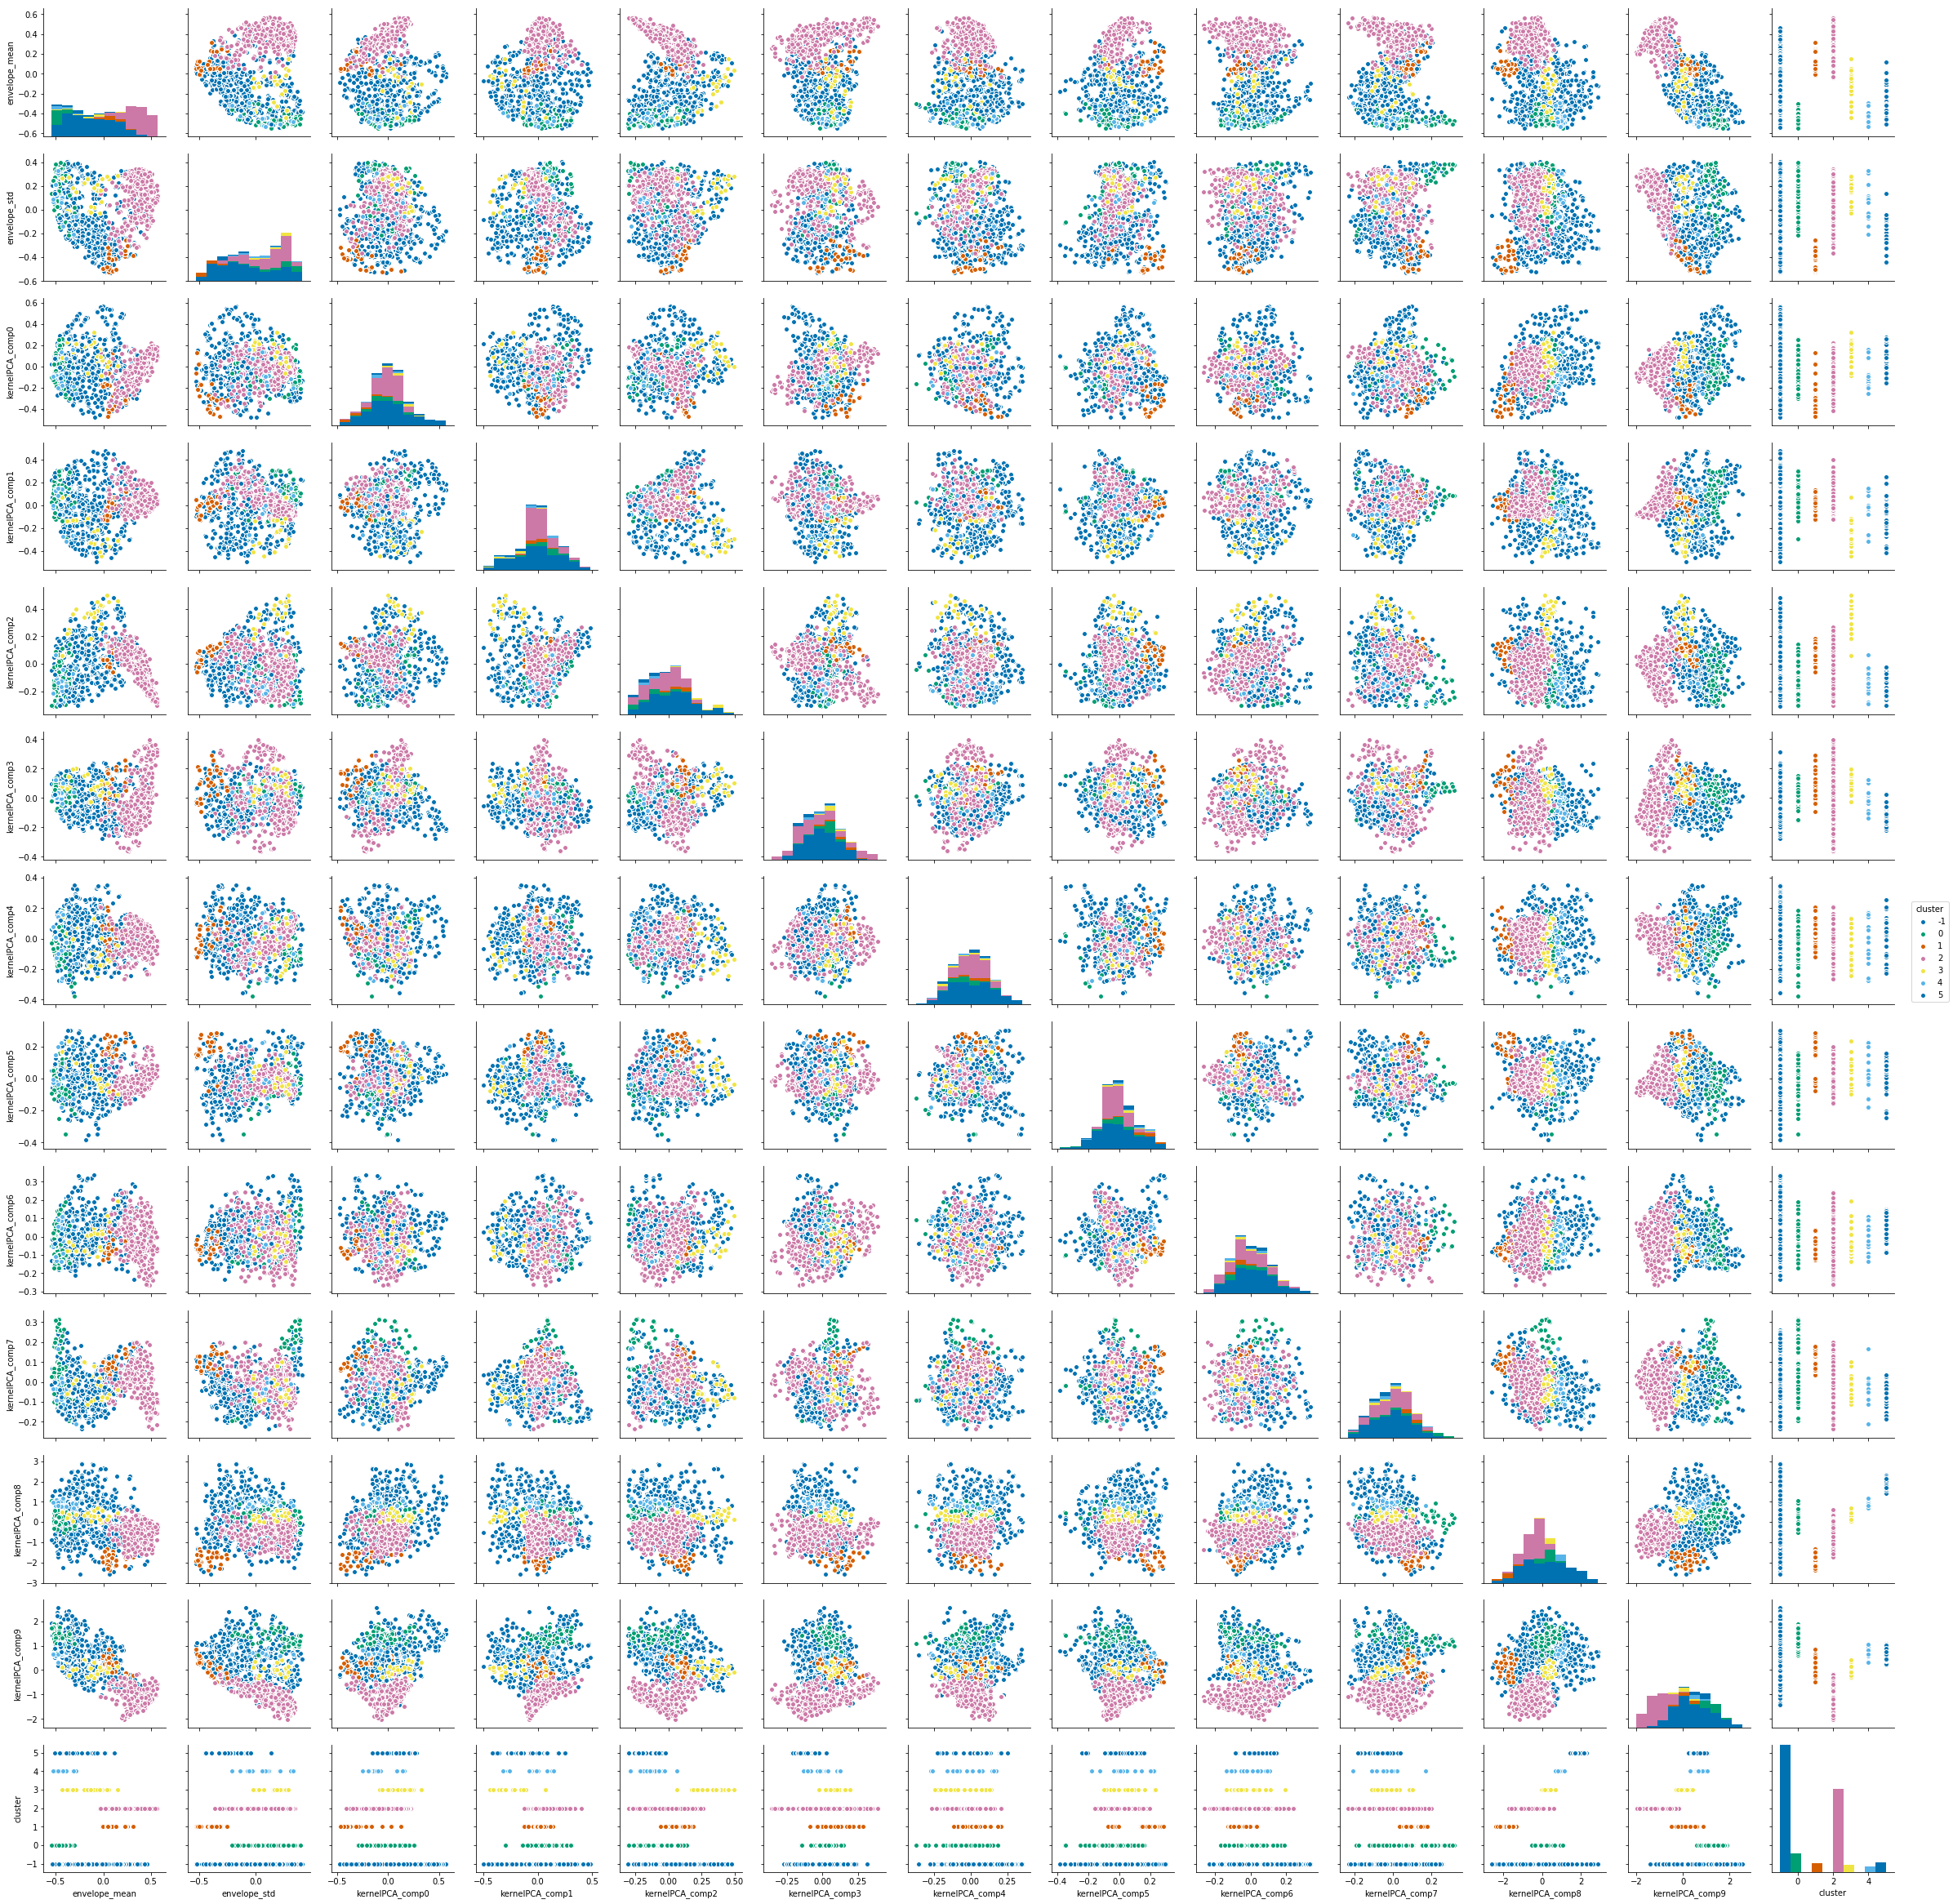

In [14]:
plt.figure()
sns.pairplot(data=features_all_df, hue="cluster", palette="colorblind")

### 5.4 Central frequency parameter across clusters

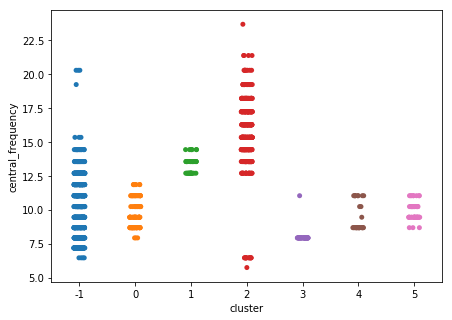

In [15]:
fm.visualization.clustering.plot_clusterwise_param_distribution(cluster_labels,
            component_data['parameters'], feature_name="central_frequency")

### 5.5 Decoding accuracy across clusters

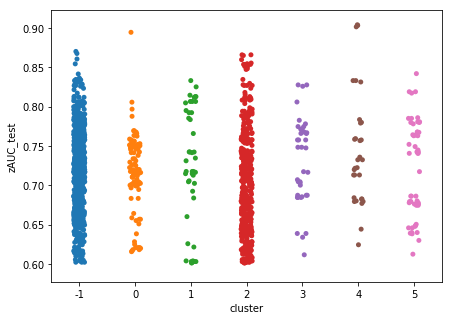

In [16]:
fm.visualization.clustering.plot_clusterwise_param_distribution(cluster_labels,
            component_data['parameters'], feature_name="zAUC_test")

## 6. Validation of the clustering

### 6.1 Mean squared error on original envelope time series

In [17]:
# representative selection based on sample with smallest within-cluster distance 

cluster_ids_repr, cluster_representatives, is_representative = fm.models.dbscan_util.cluster_representatives(clusterer,
        features_all,component_data,use_core_samples=None)                                                           

component_data['features']['is_representative'] = is_representative

Intra-Cluster Mean Squared Error by cluster [0.02371536 0.00357024 0.00239074 0.00538717 0.00265997 0.00177257
 0.00253378]


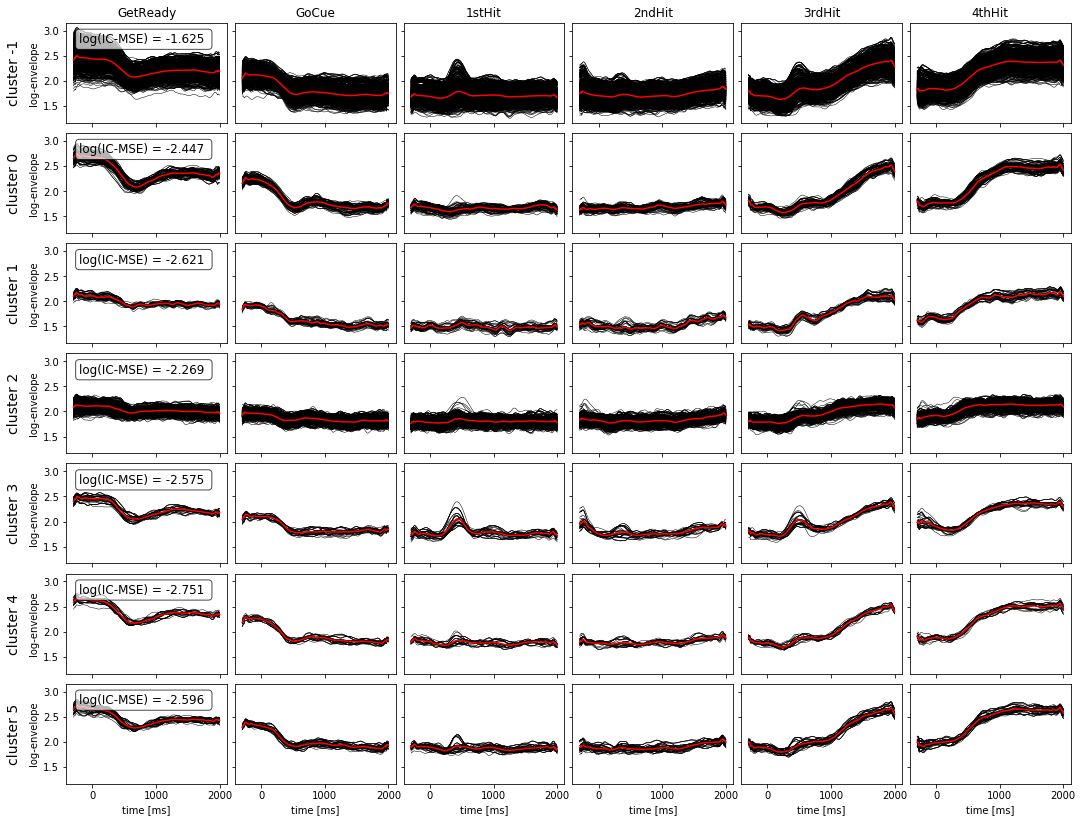

In [18]:
per_cluster_MSE, envelope_data = fm.validation.calculate_per_cluster_MSE(component_data,
                                                                        cluster_labels,
                                                                        parameters['events_for_plotting'],
                                                                        DATA_BASE_DIR)
print('Intra-Cluster Mean Squared Error by cluster {}'.format(per_cluster_MSE))

fm.visualization.clustering.plot_envelopes_per_cluster(per_cluster_MSE,envelope_data,
                                                       parameters['events_for_plotting'])

### 6.2 Plot cluster representatives

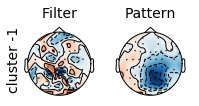

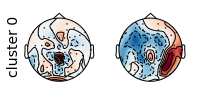

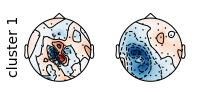

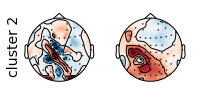

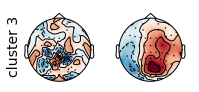

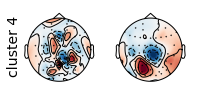

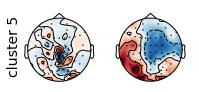

In [19]:
# calculate pattern angles to representatives

patterns, filters, channel_names = fm.data.io.load_filter_pattern(component_data)

representative_patterns = patterns.loc[[cluster_representatives['config_id'][k] for k in cluster_ids_repr], :]
representative_filters = filters.loc[[cluster_representatives['config_id'][k] for k in cluster_ids_repr], :]

fm.visualization.clustering.plot_representative_filter_pattern(representative_patterns,representative_filters,
    channel_names,cluster_ids_repr)

### 6.3 Envelope dynamics homogeneity vs. pattern homogeneity

In [20]:
pattern_angle_to_representatives = fm.util.spatial_filter_angle(patterns.as_matrix(),
                                                                    representative_patterns.as_matrix())  

# Intra-Cluster Pattern Homogeneity
ICPH = fm.validation.calculate_per_cluster_pattern_heterogeneity(cluster_ids_repr,pattern_angle_to_representatives,
                                                               cluster_labels)
print('Intra-Cluster Pattern Homogeneity by cluster {}'.format(ICPH))

Intra-Cluster Pattern Homogeneity by cluster [0.80986881 1.01865262 0.24322206 0.94064913 0.72449756 1.00948138
 0.90775582]


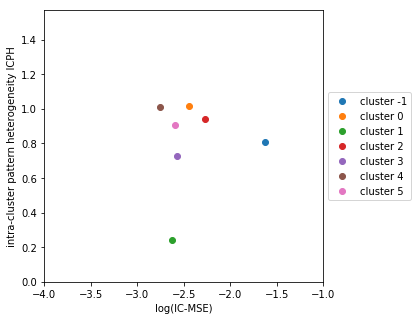

In [21]:
plt.figure(figsize=(5,5))
for idx,(a,b) in enumerate(zip(per_cluster_MSE,ICPH)):
    plt.scatter(np.log10(a),b,label='cluster '+str(idx-1))
plt.ylabel('intra-cluster pattern heterogeneity ICPH')
plt.xlabel('log(IC-MSE)')
plt.xlim(-4,-1)
plt.ylim(0,np.pi/2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()